# 图像分割

In [1]:
import os

import cv2
from skimage import img_as_float
from skimage.filters import threshold_multiotsu
from skimage.measure import label, regionprops_table

import numpy as np
import matplotlib.pyplot as plt

In [2]:
class ImgSeg():
    def __init__(self, image):
        r,g,b = cv2.split(image)
        r = (np.zeros(r.shape)).astype(np.uint8)
        self.image = cv2.merge((r,g,b))
    
    def CLAHE(self, clipLimit=5, tileGrid=4):
        lab_channels = cv2.split(cv2.cvtColor(self.image, cv2.COLOR_RGB2LAB))
        clahe = cv2.createCLAHE(clipLimit = clipLimit, tileGridSize = (tileGrid, tileGrid))
        lab_channels[0] = clahe.apply(lab_channels[0])
        self.image_enhanced = cv2.cvtColor(cv2.merge(lab_channels), cv2.COLOR_LAB2RGB)
    
    def Otsu(self, classes=4, ksize=5, sigma=9):
        image_blurred = cv2.GaussianBlur(self.image_enhanced, (ksize, ksize), sigmaX = sigma)
        image_blurred = img_as_float(cv2.cvtColor(image_blurred,cv2.COLOR_RGB2GRAY))
        thresholds = threshold_multiotsu(image_blurred, classes = classes)    
        self.labels = np.digitize(image_blurred, bins=thresholds)
    
    def Segmentation(self, threshold=40000):
        binary_mask = (np.where(self.labels==0,0,1)).astype(np.uint8)
        labels_dissected = label(binary_mask, connectivity=2)
        
        properties = regionprops_table(labels_dissected, properties=['area'])
        data = np.asarray([properties['area']]).T
        
        mask = (np.zeros((self.labels).shape)).astype(np.uint8)
        for i in range(data.shape[0]):
            label_mask = (np.where(labels_dissected==i+1,1,0)).astype(np.uint8)
            if (data[i][0] > threshold):
                mask += label_mask
        mask_canvas = np.zeros((mask.shape[0]+4, mask.shape[1]+4)).astype(np.uint8)
        mask_canvas[2:-2,2:-2] = mask
        fill_mask = np.zeros((mask_canvas.shape[0]+2, mask_canvas.shape[1]+2)).astype(np.uint8)
        cv2.floodFill(mask_canvas, fill_mask, (0,0), 255)
        mask = mask | cv2.bitwise_not(mask_canvas)[2:-2,2:-2]   
        return mask

In [3]:
src_path = "fakepath/"

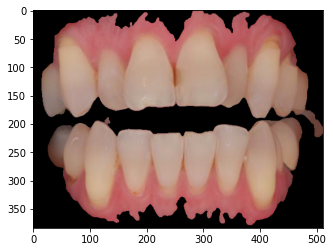

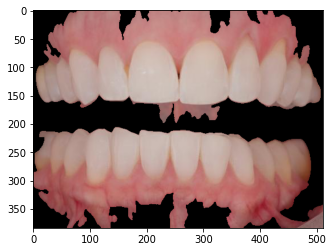

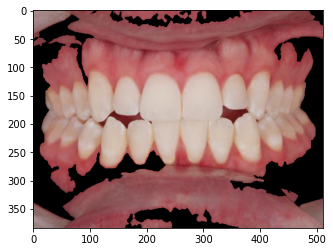

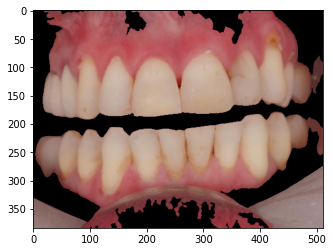

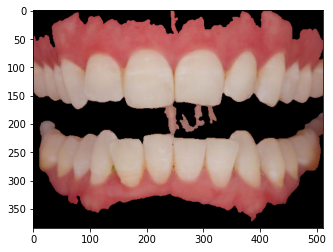

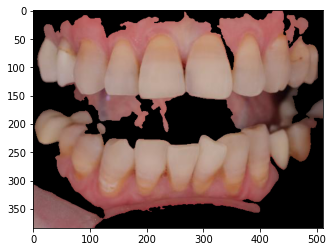

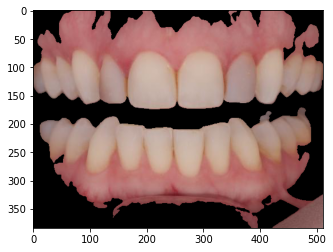

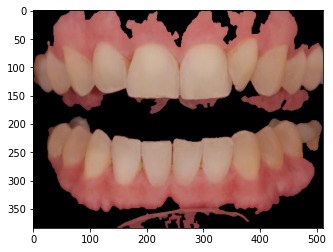

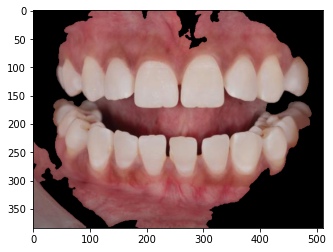

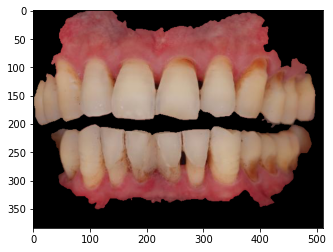

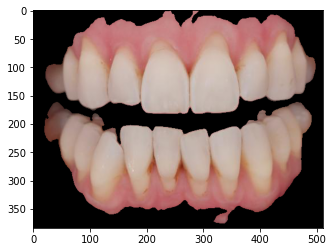

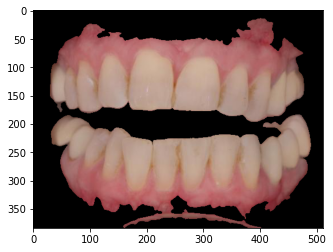

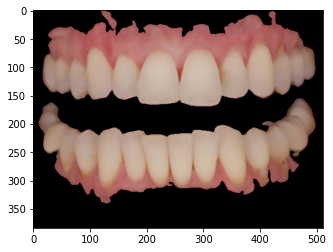

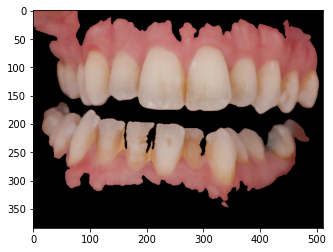

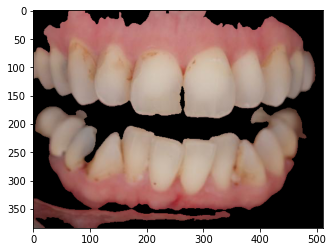

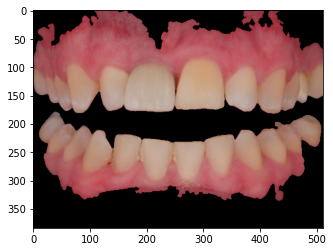

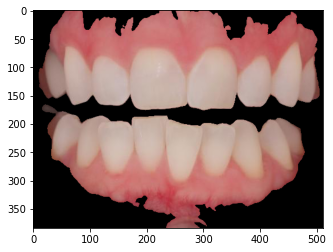

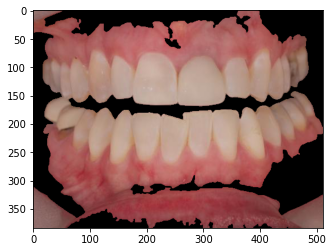

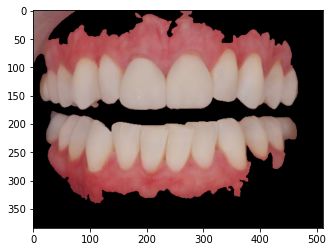

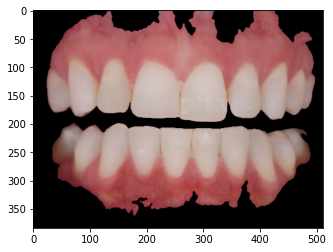

In [4]:
for _, _, files_src in os.walk(src_path):
    files_src.sort()

for src_name in files_src:
    image = cv2.cvtColor(cv2.imread(src_path + src_name), cv2.COLOR_BGR2RGB)
    Seg = ImgSeg(image)
    Seg.CLAHE()
    Seg.Otsu()
    mask = Seg.Segmentation()
    image_masked = cv2.bitwise_and(image,image,mask=mask)
    plt.imshow(image_masked)
    plt.show()
    plt.close()